In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn
from scipy.stats import entropy
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

df_drifted = pd.read_csv('telco_churn_drifted.csv')

X = df_drifted.drop('Churn', axis=1)
y = df_drifted['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [2]:
# Replace this with your actual run ID
RUN_ID = "8412651765044afdaed0e0ba229b5a93"

model_uri = f"runs:/{RUN_ID}/baseline_rf_balanced"
model = mlflow.sklearn.load_model(model_uri)

In [3]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Performance on Drifted Data:")
print(classification_report(y_test, y_pred))

Performance on Drifted Data:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       936
           1       0.69      0.47      0.56       471

    accuracy                           0.75      1407
   macro avg       0.73      0.68      0.69      1407
weighted avg       0.74      0.75      0.74      1407



In [4]:
mlflow.set_experiment("Telco Churn Monitoring")

with mlflow.start_run(run_name="Eval on Drifted Data"):
    mlflow.log_param("eval_on", "drifted_data")
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    print("Drifted performance logged to MLflow.")

Drifted performance logged to MLflow.


In [5]:
df_clean = pd.read_csv("telco_churn_clean.csv")

In [6]:
def kl_divergence(p, q, bins=20):
    """Compute KL divergence between two histograms."""
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    
    # Add epsilon to avoid log(0)
    epsilon = 1e-6
    p_hist += epsilon
    q_hist += epsilon
    
    return entropy(p_hist, q_hist)

In [7]:
features_to_check = ['MonthlyCharges', 'tenure', 'TotalCharges']

kl_scores = {}
for feature in features_to_check:
    kl = kl_divergence(df_clean[feature], df_drifted[feature])
    kl_scores[feature] = kl
    print(f"KL Divergence for {feature}: {kl:.4f}")

KL Divergence for MonthlyCharges: 0.0371
KL Divergence for tenure: 0.0000
KL Divergence for TotalCharges: 0.0004


In [8]:
for feature, score in kl_scores.items():
    mlflow.log_metric(f"kl_{feature}", score)

Saved drift plot to assets/drift_kde_plots.png


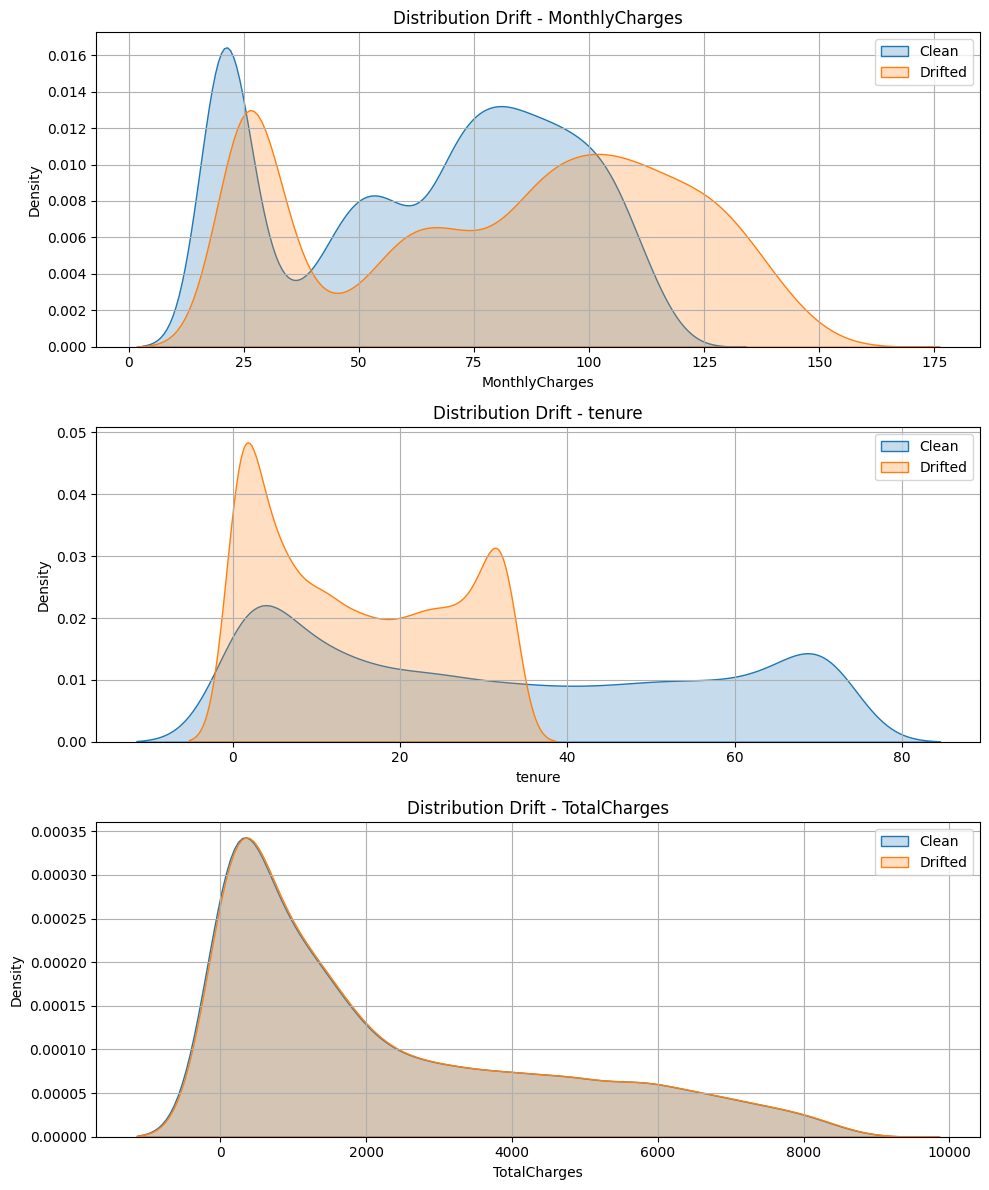

In [9]:
# Ensure the 'assets' folder exists
os.makedirs('assets', exist_ok=True)

features_to_check = ['MonthlyCharges', 'tenure', 'TotalCharges']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

for i, feature in enumerate(features_to_check):
    sns.kdeplot(df_clean[feature], label='Clean', fill=True, ax=axes[i])
    sns.kdeplot(df_drifted[feature], label='Drifted', fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution Drift - {feature}')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()

plt.savefig('assets/drift_kde_plots.png')
print("Saved drift plot to assets/drift_kde_plots.png")